In [1]:
using Pkg
pkg"activate ."
pkg"instantiate"
pkg"precompile"

  Updating registry at `C:\Users\Chiyoung Ahn\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Precompiling project...


In [2]:
using PerlaTonettiWaugh, Plots, BenchmarkTools, CSV

loaded


In [3]:
gr(fmt = :png)

Plots.GRBackend()

# Steady states

## Solving steady state solutions

Set up parameters and find the corresponding stationary solution:

Below are the results from the **updated** matlab calibration with the corresponding letters. Here I added the $\mu$ parameter in the calibration routine to fit the firm dynamic moments. Fit improved a lot and it generated a negative drift term which is what we need to keep S from going negative.


In [4]:
changed_parameters = true # set this to true if you drastically change the parameters

true

Side note on previous version. Essentially, under this calibration, the parameters are very simmilar. Theta, chi, kappa are quite close to what we had in the prior version.

In [5]:
# Define common objects. 
parameters = parameter_defaults()

settings = settings_defaults()
settings = merge(settings, (transition_penalty_coefficient = 1.0, ))
z_grid = settings.z
P = length(z_grid)

d_0 = 1 + (parameters.d-1).*1.10 # Here is the 10 percent tariff increase
d_T = parameters.d

params_0 = merge(parameters, (d = d_0, )) # parameters to be used at t = 0
params_T = merge(parameters, (d = d_T, )) # parameters to be used at t = T

# initial value for numerical solver on (g, z_hat, Omega)
initial_x = [0.02; 2; .57]

# solve for stationary solution at t = 0
stationary_sol_0 = stationary_algebraic(params_0, initial_x) # solution at t = 0
stationary_sol = stationary_algebraic(params_T, initial_x) # solution at t = T

Ω_0 = stationary_sol_0.Ω;
Ω_T = stationary_sol.Ω;

In [6]:
d_0 

3.17283

In [7]:
print(stationary_sol.U_bar(1),'\n') 
print(stationary_sol_0.U_bar(1),'\n')
print(stationary_sol_0.S,'\n')
print(stationary_sol.S,'\n')

40.758466349188666
36.77172415400971
0.11010701157463201
0.1183916590948936


Note that $S$ is now well above zero, not like in the old calibrations. 

## Welfare in Steady States

### Steady state at `T`

In [8]:
stationary_sol.U_bar(1)

40.758466349188666

### Steady state at `0`

In [9]:
stationary_sol_0.U_bar(1)

36.77172415400971

### Outstanding Issue \#1: Sensitivity of growth to trade.

This is a big difference relative to previous version. As noted above, with parameter values that are quite similar to what we had before, the growth rate is changing a lot with only a very small change in trade flows. Why?

In [10]:
@show stationary_sol.g, stationary_sol_0.g;

(stationary_sol.g, stationary_sol_0.g) = (0.020015751789702305, 0.01833907098577978)


---

# Transition dynamics

Setup for optimizer:

In [11]:
settings = merge(settings, (params_T = params_T, stationary_sol_T = stationary_numerical(params_T, z_grid), Ω_0 = Ω_0, transition_iterations = 0, T = 75.0));

Use the solution found with calibrated parameters above for `E` (for `T = 75` case)

In [12]:
transition_x0_T75 = [-0.993536, -0.833713, -0.612099, -0.26546, -0.169125, -0.143064, -0.113853, -0.11014, -0.0864335, -0.0616799, -0.0569361, -0.0405799, -0.0300324, -0.0246712, -0.0238654, -0.0232664, -0.0127355, -0.00957687, -0.00885024, -0.00700805, -0.00670916, -0.00410799, -0.0027411, -0.00250823, -0.00215498, -0.00206202, -0.000930253, -0.000409824, -0.000155193, -1.5986e-5]
settings = merge(settings, (transition_x0 = fill(0.0, 10), 
        transition_lb = fill(transition_x0_T75[end], 10),
        transition_ub = fill(0.0, 10),
        T = 100.0));

Find the corresponding solution

In [13]:
@time result = solve_full_model(merge(settings, (transition_iterations = (changed_parameters ? 1000 : 1),)); 
    impose_E_monotonicity_constraints = true,
    write_csv = true, csvpath = "somecsv.csv", 
    run_global = true,
    front_nodes_appended = transition_x0_T75)
solved = result.solution;
E_nodes = result.E_nodes;
solved = solved.results;

┌ Warning: length(settings.transition_x0) != length(settings.weights); 
│           setting weights as (x -> x < 10 ? 10. - x : 1.).(1:1:length(settings.transition_x0))
└ @ PerlaTonettiWaugh C:\Users\Chiyoung Ahn\.julia\dev\PerlaTonettiWaugh\src\full\transition.jl:29


Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
2.04 secs, 2 evals, 1 steps, fitness=0.020441738
3.34 secs, 4 evals, 2 steps, improv/step: 0.500 (last = 1.0000), fitness=0.020441738
4.61 secs, 6 evals, 3 steps, improv/step: 0.333 (last = 0.0000), fitness=0.020432525
6.04 secs, 8 evals, 4 steps, improv/step: 0.500 (last = 1.0000), fitness=0.020432525
7.55 secs, 10 evals, 5 steps, improv/step: 0.400 (last = 0.0000), fitness=0.020432525
9.06 secs, 12 evals, 6 steps, improv/step: 0.500 (last = 1.0000), fitness=0.020356255
10.37 secs, 14 evals, 7 steps, improv/step: 0.429 (last = 0.0000), fitness=0.018318634
11.68 secs, 16 evals, 8 steps, improv/step: 0.500 (last = 1.0000), fitness=0.018318634
12.34 secs, 17 evals, 9 steps, improv/step: 0.556 (last = 1.0000), fitness=0.01831

104.61 secs, 157 evals, 92 steps, improv/step: 0.435 (last = 0.0000), fitness=0.018318634
105.25 secs, 158 evals, 93 steps, improv/step: 0.441 (last = 1.0000), fitness=0.018318634
105.90 secs, 159 evals, 94 steps, improv/step: 0.436 (last = 0.0000), fitness=0.018318634
106.61 secs, 160 evals, 95 steps, improv/step: 0.432 (last = 0.0000), fitness=0.018318634
108.00 secs, 162 evals, 96 steps, improv/step: 0.427 (last = 0.0000), fitness=0.018318634
108.79 secs, 163 evals, 97 steps, improv/step: 0.423 (last = 0.0000), fitness=0.018318634
109.47 secs, 164 evals, 98 steps, improv/step: 0.418 (last = 0.0000), fitness=0.018318634
110.14 secs, 165 evals, 99 steps, improv/step: 0.414 (last = 0.0000), fitness=0.018318634
110.89 secs, 166 evals, 100 steps, improv/step: 0.410 (last = 0.0000), fitness=0.018318634
111.56 secs, 167 evals, 101 steps, improv/step: 0.406 (last = 0.0000), fitness=0.018318634
112.19 secs, 168 evals, 102 steps, improv/step: 0.402 (last = 0.0000), fitness=0.018318634
113.50 

179.43 secs, 275 evals, 183 steps, improv/step: 0.317 (last = 0.0000), fitness=0.018318634
180.06 secs, 276 evals, 184 steps, improv/step: 0.315 (last = 0.0000), fitness=0.018318634
180.68 secs, 277 evals, 185 steps, improv/step: 0.314 (last = 0.0000), fitness=0.018318634
181.31 secs, 278 evals, 186 steps, improv/step: 0.312 (last = 0.0000), fitness=0.018318634
181.93 secs, 279 evals, 187 steps, improv/step: 0.310 (last = 0.0000), fitness=0.018318634
182.55 secs, 280 evals, 188 steps, improv/step: 0.309 (last = 0.0000), fitness=0.018318634
183.16 secs, 281 evals, 189 steps, improv/step: 0.307 (last = 0.0000), fitness=0.018318634
183.79 secs, 282 evals, 190 steps, improv/step: 0.305 (last = 0.0000), fitness=0.018318634
185.03 secs, 284 evals, 191 steps, improv/step: 0.304 (last = 0.0000), fitness=0.018318634
185.64 secs, 285 evals, 192 steps, improv/step: 0.302 (last = 0.0000), fitness=0.018318634
186.88 secs, 287 evals, 193 steps, improv/step: 0.301 (last = 0.0000), fitness=0.018318634

249.47 secs, 386 evals, 274 steps, improv/step: 0.274 (last = 0.0000), fitness=0.008061738
250.31 secs, 387 evals, 275 steps, improv/step: 0.273 (last = 0.0000), fitness=0.008061738
251.10 secs, 388 evals, 276 steps, improv/step: 0.272 (last = 0.0000), fitness=0.008061738
251.82 secs, 389 evals, 277 steps, improv/step: 0.271 (last = 0.0000), fitness=0.008061738
252.53 secs, 390 evals, 278 steps, improv/step: 0.270 (last = 0.0000), fitness=0.008061738
253.99 secs, 392 evals, 279 steps, improv/step: 0.269 (last = 0.0000), fitness=0.008061738
255.27 secs, 394 evals, 280 steps, improv/step: 0.268 (last = 0.0000), fitness=0.008061738
255.89 secs, 395 evals, 281 steps, improv/step: 0.267 (last = 0.0000), fitness=0.008061738
256.51 secs, 396 evals, 282 steps, improv/step: 0.270 (last = 1.0000), fitness=0.008061738
257.13 secs, 397 evals, 283 steps, improv/step: 0.269 (last = 0.0000), fitness=0.008061738
257.76 secs, 398 evals, 284 steps, improv/step: 0.268 (last = 0.0000), fitness=0.008061738

318.99 secs, 492 evals, 365 steps, improv/step: 0.233 (last = 0.0000), fitness=0.008061738
319.62 secs, 493 evals, 366 steps, improv/step: 0.232 (last = 0.0000), fitness=0.008061738
320.25 secs, 494 evals, 367 steps, improv/step: 0.232 (last = 0.0000), fitness=0.008061738
321.52 secs, 496 evals, 368 steps, improv/step: 0.231 (last = 0.0000), fitness=0.008061738
322.14 secs, 497 evals, 369 steps, improv/step: 0.230 (last = 0.0000), fitness=0.008061738
322.78 secs, 498 evals, 370 steps, improv/step: 0.230 (last = 0.0000), fitness=0.008061738
323.42 secs, 499 evals, 371 steps, improv/step: 0.229 (last = 0.0000), fitness=0.008061738
324.70 secs, 501 evals, 372 steps, improv/step: 0.228 (last = 0.0000), fitness=0.008061738
325.33 secs, 502 evals, 373 steps, improv/step: 0.228 (last = 0.0000), fitness=0.008061738
325.96 secs, 503 evals, 374 steps, improv/step: 0.227 (last = 0.0000), fitness=0.008061738
326.60 secs, 504 evals, 375 steps, improv/step: 0.227 (last = 0.0000), fitness=0.008061738

386.43 secs, 593 evals, 455 steps, improv/step: 0.202 (last = 0.0000), fitness=0.008061738
387.05 secs, 594 evals, 456 steps, improv/step: 0.202 (last = 0.0000), fitness=0.008061738
387.65 secs, 595 evals, 457 steps, improv/step: 0.201 (last = 0.0000), fitness=0.008061738
388.91 secs, 597 evals, 458 steps, improv/step: 0.201 (last = 0.0000), fitness=0.008061738
389.52 secs, 598 evals, 459 steps, improv/step: 0.200 (last = 0.0000), fitness=0.008061738
390.14 secs, 599 evals, 460 steps, improv/step: 0.200 (last = 0.0000), fitness=0.008061738
390.74 secs, 600 evals, 461 steps, improv/step: 0.200 (last = 0.0000), fitness=0.008061738
391.37 secs, 601 evals, 462 steps, improv/step: 0.199 (last = 0.0000), fitness=0.008061738
391.98 secs, 602 evals, 463 steps, improv/step: 0.199 (last = 0.0000), fitness=0.008061738
392.61 secs, 603 evals, 464 steps, improv/step: 0.198 (last = 0.0000), fitness=0.008061738
393.80 secs, 605 evals, 465 steps, improv/step: 0.198 (last = 0.0000), fitness=0.008061738

451.09 secs, 696 evals, 546 steps, improv/step: 0.185 (last = 1.0000), fitness=0.008061738
451.72 secs, 697 evals, 547 steps, improv/step: 0.185 (last = 0.0000), fitness=0.008061738
452.34 secs, 698 evals, 548 steps, improv/step: 0.184 (last = 0.0000), fitness=0.008061738
452.97 secs, 699 evals, 549 steps, improv/step: 0.184 (last = 0.0000), fitness=0.008061738
454.21 secs, 701 evals, 550 steps, improv/step: 0.184 (last = 0.0000), fitness=0.008061738
454.84 secs, 702 evals, 551 steps, improv/step: 0.183 (last = 0.0000), fitness=0.008061738
455.48 secs, 703 evals, 552 steps, improv/step: 0.183 (last = 0.0000), fitness=0.008061738
456.12 secs, 704 evals, 553 steps, improv/step: 0.183 (last = 0.0000), fitness=0.008061738
456.77 secs, 705 evals, 554 steps, improv/step: 0.182 (last = 0.0000), fitness=0.008061738
457.40 secs, 706 evals, 555 steps, improv/step: 0.182 (last = 0.0000), fitness=0.008061738
458.13 secs, 707 evals, 556 steps, improv/step: 0.182 (last = 0.0000), fitness=0.008061738

517.20 secs, 801 evals, 637 steps, improv/step: 0.171 (last = 0.0000), fitness=0.008061738
517.83 secs, 802 evals, 638 steps, improv/step: 0.171 (last = 0.0000), fitness=0.008061738
518.48 secs, 803 evals, 639 steps, improv/step: 0.171 (last = 0.0000), fitness=0.008061738
519.13 secs, 804 evals, 640 steps, improv/step: 0.170 (last = 0.0000), fitness=0.008061738
519.76 secs, 805 evals, 641 steps, improv/step: 0.170 (last = 0.0000), fitness=0.008061738
520.40 secs, 806 evals, 642 steps, improv/step: 0.170 (last = 0.0000), fitness=0.008061738
521.04 secs, 807 evals, 643 steps, improv/step: 0.170 (last = 0.0000), fitness=0.008061738
522.25 secs, 809 evals, 644 steps, improv/step: 0.169 (last = 0.0000), fitness=0.008061738
522.87 secs, 810 evals, 645 steps, improv/step: 0.169 (last = 0.0000), fitness=0.008061738
523.50 secs, 811 evals, 646 steps, improv/step: 0.169 (last = 0.0000), fitness=0.008061738
524.74 secs, 813 evals, 647 steps, improv/step: 0.168 (last = 0.0000), fitness=0.008061738

582.79 secs, 902 evals, 728 steps, improv/step: 0.152 (last = 0.0000), fitness=0.008061738
583.45 secs, 903 evals, 729 steps, improv/step: 0.152 (last = 0.0000), fitness=0.008061738
584.09 secs, 904 evals, 730 steps, improv/step: 0.152 (last = 0.0000), fitness=0.008061738
584.73 secs, 905 evals, 731 steps, improv/step: 0.152 (last = 0.0000), fitness=0.008061738
585.38 secs, 906 evals, 732 steps, improv/step: 0.152 (last = 0.0000), fitness=0.008061738
586.00 secs, 907 evals, 733 steps, improv/step: 0.151 (last = 0.0000), fitness=0.008061738
586.64 secs, 908 evals, 734 steps, improv/step: 0.151 (last = 0.0000), fitness=0.008061738
587.28 secs, 909 evals, 735 steps, improv/step: 0.151 (last = 0.0000), fitness=0.008061738
587.93 secs, 910 evals, 736 steps, improv/step: 0.151 (last = 0.0000), fitness=0.008061738
588.58 secs, 911 evals, 737 steps, improv/step: 0.151 (last = 0.0000), fitness=0.008061738
589.22 secs, 912 evals, 738 steps, improv/step: 0.150 (last = 0.0000), fitness=0.008061738

646.58 secs, 998 evals, 819 steps, improv/step: 0.143 (last = 0.0000), fitness=0.008061738
647.22 secs, 999 evals, 820 steps, improv/step: 0.143 (last = 0.0000), fitness=0.008061738
647.87 secs, 1000 evals, 821 steps, improv/step: 0.143 (last = 0.0000), fitness=0.008061738
648.52 secs, 1001 evals, 822 steps, improv/step: 0.142 (last = 0.0000), fitness=0.008061738
649.16 secs, 1002 evals, 823 steps, improv/step: 0.142 (last = 0.0000), fitness=0.008061738
649.81 secs, 1003 evals, 824 steps, improv/step: 0.142 (last = 0.0000), fitness=0.008061738
650.49 secs, 1004 evals, 825 steps, improv/step: 0.142 (last = 0.0000), fitness=0.008061738
651.13 secs, 1005 evals, 826 steps, improv/step: 0.142 (last = 0.0000), fitness=0.008061738
651.78 secs, 1006 evals, 827 steps, improv/step: 0.141 (last = 0.0000), fitness=0.008061738
652.45 secs, 1007 evals, 828 steps, improv/step: 0.141 (last = 0.0000), fitness=0.008061738
653.10 secs, 1008 evals, 829 steps, improv/step: 0.141 (last = 0.0000), fitness=0.

709.15 secs, 1096 evals, 910 steps, improv/step: 0.133 (last = 0.0000), fitness=0.008061738
709.78 secs, 1097 evals, 911 steps, improv/step: 0.133 (last = 0.0000), fitness=0.008061738
710.41 secs, 1098 evals, 912 steps, improv/step: 0.133 (last = 0.0000), fitness=0.008061738
711.05 secs, 1099 evals, 913 steps, improv/step: 0.133 (last = 0.0000), fitness=0.008061738
711.69 secs, 1100 evals, 914 steps, improv/step: 0.132 (last = 0.0000), fitness=0.008061738
712.33 secs, 1101 evals, 915 steps, improv/step: 0.132 (last = 0.0000), fitness=0.008061738
712.97 secs, 1102 evals, 916 steps, improv/step: 0.133 (last = 1.0000), fitness=0.008061738
713.58 secs, 1103 evals, 917 steps, improv/step: 0.133 (last = 0.0000), fitness=0.008061738
714.20 secs, 1104 evals, 918 steps, improv/step: 0.133 (last = 0.0000), fitness=0.008061738
714.82 secs, 1105 evals, 919 steps, improv/step: 0.133 (last = 0.0000), fitness=0.008061738
715.44 secs, 1106 evals, 920 steps, improv/step: 0.133 (last = 0.0000), fitness=

769.55 secs, 1189 evals, 1000 steps, improv/step: 0.129 (last = 0.0000), fitness=0.008061738

Optimization stopped after 1001 steps and 770.1779999732971 seconds
Termination reason: Max number of steps (1000) reached
Steps per second = 1.2996995500192237
Function evals per second = 1.5450973671557207
Improvements/step = 0.129
Total function evaluations = 1190


Best candidate found: [-1.43605e-5, -7.3352e-7, -6.44247e-6, -2.2207e-6, -1.14575e-6, -1.4693e-5, -1.49089e-6, -1.09154e-5, -1.00221e-5, -1.44608e-5]

Fitness: 0.008061738

820.432094 seconds (2.24 G allocations: 2.950 TiB, 17.76% gc time)


---
## Welfare Gains

In [14]:
print("Utility in initial SS: ", stationary_sol_0.U_bar(1),"\n")
print("Utility in new SS: ", stationary_sol.U_bar(1),"\n")

Utility in initial SS: 36.77172415400971
Utility in new SS: 40.758466349188666


In [15]:
print("Utility immediately after change ", solved.U[1],"\n")

Utility immediately after change 54.09132328910333


#### Summary so far...

In the old paper, what we did was take U_0_ss at some date t, then compare it to U_ss at the same date t. This is like an instentanous jump to the new ss. This is what the first cell is looking at and note that this is like a 17 percent increase in utility. Higher than what we had in the paper, but in of the same order of magnitude. 

The next cell reprots the utility just after the change. Utility here includes the future path of consumption and change in growth rate, so it "bakes in" the transition path. Here it goes up by much more than utility in the new SS. This is what I was expecting given the dynamics of consumption. 

Just a reminder about how the function `counsumption_equivalent(U_new, U_old, parameters)` works, it takes U_new and then U_old in that order, then evaluates the **gross** increase in consumption. 100 times this value **minus one** gives the permanent, percent increase in consumption required to make the agent indifferent between the two paths. 

In [16]:
T = solved.t[end]
lambda_ss = 100*(consumption_equivalent(stationary_sol.U_bar(0), stationary_sol_0.U_bar(0), parameters)-1)

print("SS to SS welfare gain: ", lambda_ss,"\n")

SS to SS welfare gain: 8.118554194374571


In [17]:
lambda_tpath = 100*(consumption_equivalent(solved.U[1], stationary_sol_0.U_bar(0), parameters)-1)

print("Inclusive of the Transition Path: ", lambda_tpath,"\n")

Inclusive of the Transition Path: 44.0126639311885


### Relative to initial notebook computations

- SS to SS, the issue here is that we should compare **at date 0** utility in the first ss vs. the second ss. This is what we must have been doing in the previous version of the paper. The previous calulation in the old notebook had 
```consumption_equivalent(solved.U[end], stationary_sol_0.U_bar(T), parameters)```
which took **date T** utility and compard them. The problem is that this now depends on date T. So if we picked T to be arbitraily large, then utility will be arbitraily different.

- Following the same logic, the transition path should compare **date 0** utility with the initial value from the transition path. So what we want to do is to compare everything at 0. In the previous calculation, we had
```consumption_equivalent(solved.U[1], stationary_sol_0.U_bar(T), parameters)```
were comparing the initial utility relative to ss utility on the old path at date T. So the initial blue point below versues the last orange dashed point. **See the figure below**

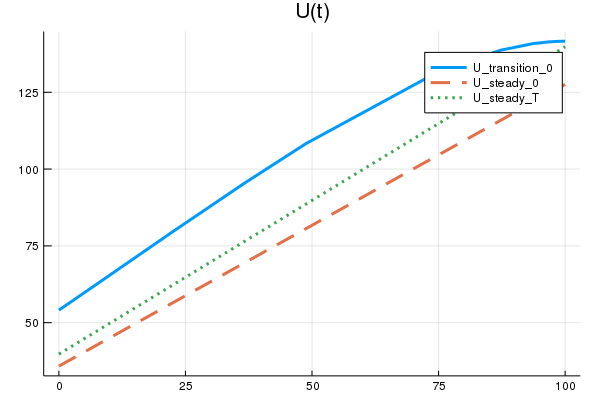

In [18]:
plot(solved.t, 
    [solved.U, stationary_sol_0.U_bar, stationary_sol.U_bar], 
    label = ["U_transition_0", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

### Outstanding Issue \#2: Welfare Gains still depend on T in transition path.

The stuff above I think is correct, the one issue is why does the welfare gains, inclusive of the transition path seem to depend on T??? So change T above from 40 to 75 or 100, then the welfare gains fall alot? Why?

---
## Plotting

In [19]:
solved.U[end]

141.6100269887104

## Plots for Ω and residuals

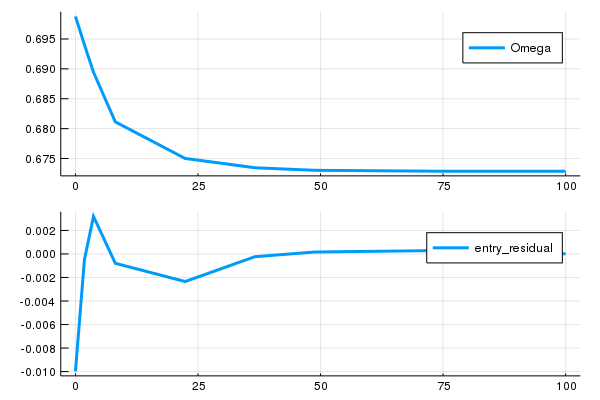

In [20]:
#solved = solved.results;
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

## Primary Plots

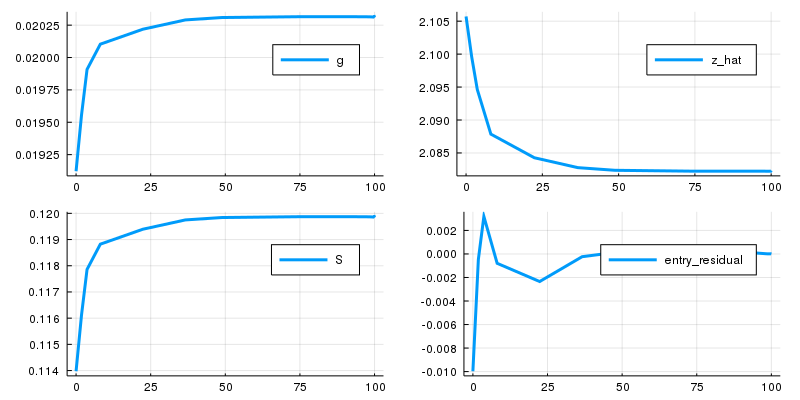

In [21]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2), size = (800, 400))

## Static Equations

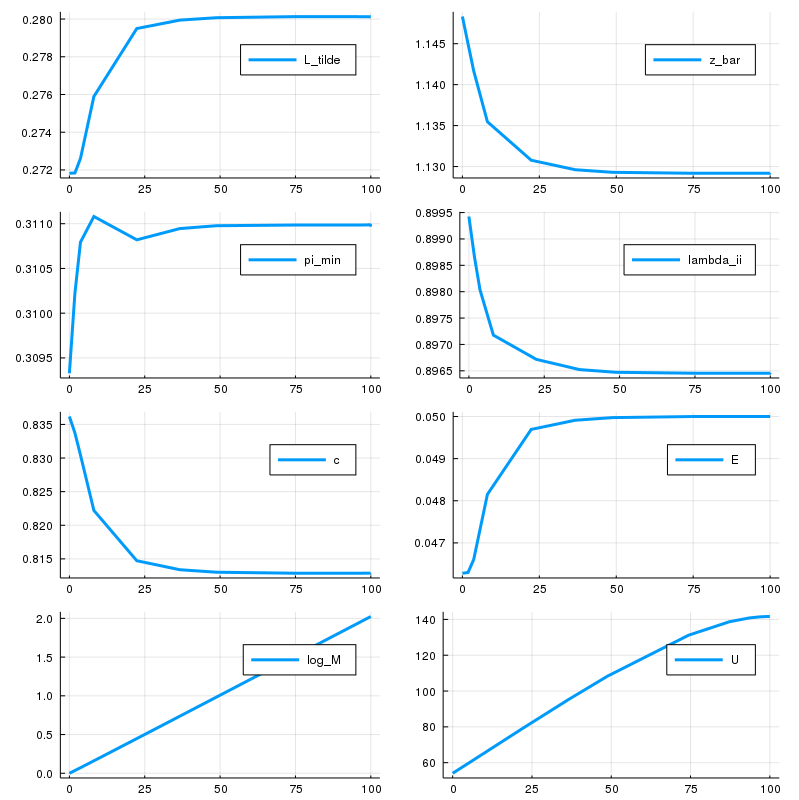

In [22]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_min, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, layout=(4,2), size = (800, 800))

# Welfare analysis

### `log_M(t)`

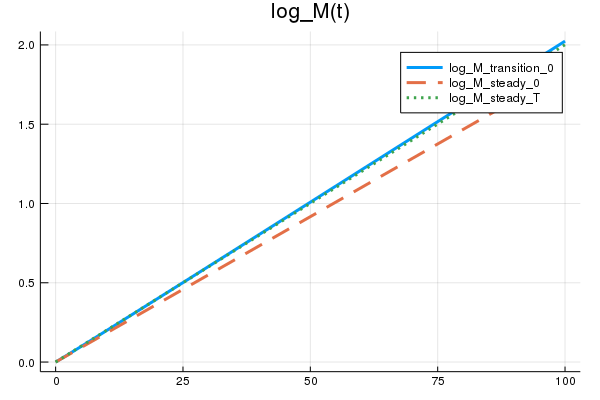

In [23]:
# define log_M with steady state g
log_M_steady_0(t) = stationary_sol_0.g * t
log_M_steady_T(t) = stationary_sol.g * t

# generate the plot!
plot(solved.t, 
    [solved.log_M, log_M_steady_0, log_M_steady_T], 
    label = ["log_M_transition_0", "log_M_steady_0", "log_M_steady_T"] ,
    title = "log_M(t)", linestyle = :auto, lw = 3)

### `Ω(t)`

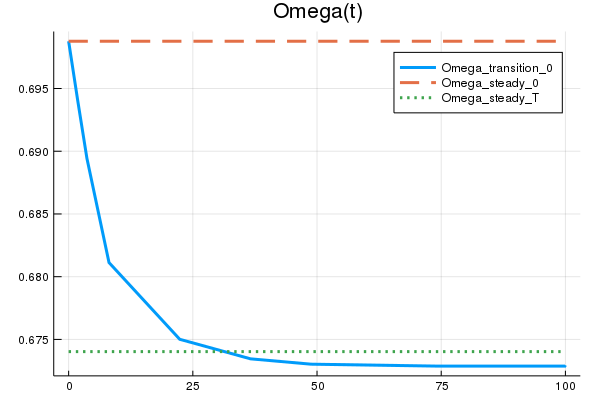

In [24]:
# define Ω function (constant)
Ω_steady_0(t) = stationary_sol_0.Ω
Ω_steady_T(t) = stationary_sol.Ω

# generate the plot!
plot(solved.t, 
    [solved.Ω, Ω_steady_0, Ω_steady_T], 
    label = ["Omega_transition_0", "Omega_steady_0", "Omega_steady_T"] ,
    title = "Omega(t)", linestyle = :auto, lw = 3)

### `c(t)`

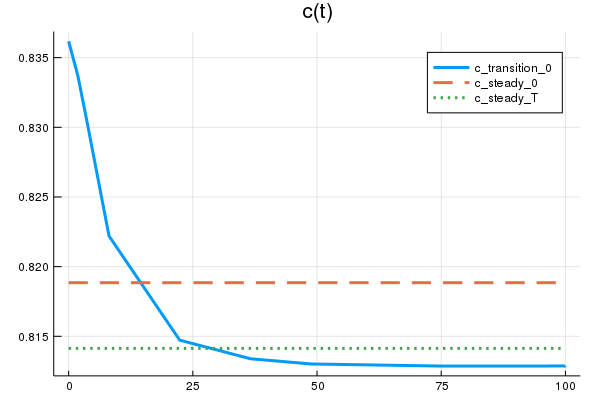

In [25]:
# define c function (constant)
c_steady_0(t) = stationary_sol_0.c
c_steady_T(t) = stationary_sol.c

# generate the plot!
plot(solved.t, 
    [solved.c, c_steady_0, c_steady_T], 
    label = ["c_transition_0", "c_steady_0", "c_steady_T"] ,
    title = "c(t)", linestyle = :auto, lw = 3)

### `U(t)`

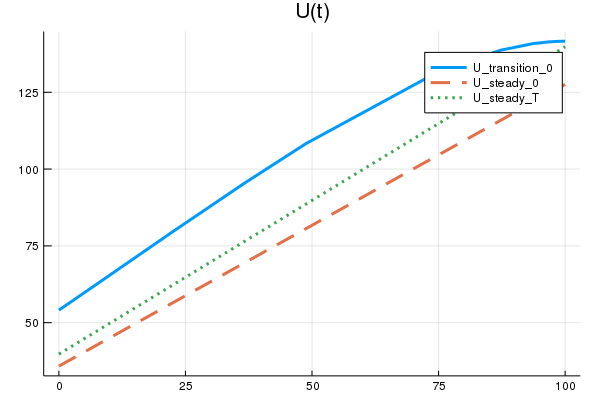

In [26]:
# generate the plot!
plot(solved.t, 
    [solved.U, stationary_sol_0.U_bar, stationary_sol.U_bar], 
    label = ["U_transition_0", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

## Consumption equivalent for search threshold (`M(0)`)
See computational appendix for details.

### `M(0)` by two steady states (autarky and steady state at `T`)

In [27]:
T = solved.t[end]
consumption_equivalent(solved.U[end], stationary_sol_0.U_bar(T), parameters)

1.3247159102641266

### `M(0)` by autarky and transition from `t=0`

In [28]:
T = solved.t[end]
consumption_equivalent(solved.U[1], stationary_sol_0.U_bar(100.0), parameters)

0.23011501153496672

Here's one at `T = 75`:

In [29]:
T = solved.t[end]
consumption_equivalent(solved.U[1], stationary_sol_0.U_bar(75.0), parameters)

0.36396438110308305

But if we include the transition path, this falls a lot. Like down to 13 percent gain. 

In [30]:
stationary_sol.U_bar(90)/stationary_sol.U_bar(89)

1.0077684148120574

In [31]:
# solved 
# Run the above to see the whole dataframe

In [32]:
using DataFrames

df_stationary = DataFrame(t = -1.00, g =stationary_sol_0.g, λ_ii = stationary_sol_0.λ_ii, c = stationary_sol_0.c, L_tilde = stationary_sol_0.L_tilde, Ω = stationary_sol_0.Ω);

In [33]:
CSV.write("stationary_results.csv", df_stationary)

"stationary_results.csv"